# Offline pupillometry
This notebook provides an example of how to use Meye to get pupillometry data from a prerecorded video file.

## Installation
Follow the requiremets described in the repo [homepage](https://github.com/fabiocarrara/meye).  

Download locally the NN model in a location in your computer. 

For **Meye** you need Python 3 environment with the following packages installed:
- tensorflow >= 2.4
- imageio, imageio-ffmpeg
- scipy
- tqdm

For running the rest of this **notebook** you will need:
- cv2
- numpy
- pandas
- matplotlib
- scikit-image

In [1]:
# Import required packages for this notebook
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
%matplotlib inline
import cv2 as cv
from skimage.measure import label, regionprops

import winsound # makes a beep sound when whole video analysis is finished
BEEP_FREQ = 2500  # Set Frequency To 2500 Hertz
BEEP_DURATION_MS = 1000  # Set Duration To 1000 ms == 1 second

# Import Meye package
import meye

# Import the NN model
from tensorflow.keras.models import load_model

# Utility function to predict pupil statistics
def predict(eye):
        eye = np.array(eye).astype(np.float32) / 255.0
        eye = eye[None, :, :, None]
        return model.predict(eye)


### Specify the full paths
 - **MODELPATH**: the NN model that you downloaded locally on your PC
 - **VIDEOPATH**: the video file you want to analyze

In [2]:
MODELPATH = r"C:\Users\Leonardo\Documents\Python\pupilNN\meye-segmentation_i128_s4_c1_f16_g1_a-relu.hdf5"
VIDEOPATH = r"D:\PizzorussoLAB\proj_Fasting\exp_acuity-2P\2P_data\cage_gNex6\20210107\gNex6_postFast_2021-01-07-095936-0000.avi"

model = load_model(MODELPATH)

## Crop the movie

The NN makes predition on images of a fixed size. The following section provide some code to interactively and iteratively perform a square region of interest (ROI) around the eye.  
You need to specify and eventually adjust 2 parameters:
- **TOPLEFT**: tuple containing the XY (columns,rows) coordinates of the top-left corner of the ROI
- **ROIWIDTH**: size of the side of the square ROI in pixels

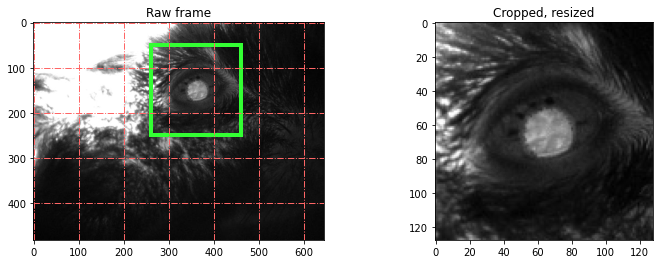

In [6]:
# EDIT PARAMETERS
# Manually select a square ROI for the eye, by specifying the XY coordinates
# and the width of the square in pixels
# ---------------------------------------------------
TOPLEFT = (260,50) # X,Y coordinates
ROIWIDTH = 200 # width on the square ROI in pixels
# ---------------------------------------------------

cap = cv.VideoCapture(VIDEOPATH)
try:
    numOfFrames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    chosenFrame = np.random.randint(1, high=numOfFrames)# Choose randomly a frame
    
    cap.set(cv.CAP_PROP_POS_FRAMES,chosenFrame)
    _, frame = cap.read() # Read the frame
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)# Convert to grayscale
except:
    print('An error occurred while getting a frame for the video.')
finally:
    cap.release()

fHeight, fWidth = frame.shape
cropL = TOPLEFT[0]
cropR = TOPLEFT[0]+ROIWIDTH
cropT = TOPLEFT[1]
cropB = TOPLEFT[1]+ROIWIDTH

# Default crop is the selected crop is out of the image boundaries
if (any(np.array([cropT,cropB])>fHeight)) or (any(np.array([cropL,cropR])>fWidth)):
    print('Crop limits exceed image size. Performing a default crop instead.')
    cropL = round((fWidth-ROIWIDTH) / 2)
    cropR = round((fWidth+ROIWIDTH) / 2)
    cropT = round((fHeight-ROIWIDTH) / 2)
    cropB = round((fHeight+ROIWIDTH) / 2)                           
       
# Crop and resize 
requiredFrameSize = model.input.shape[1:3]
crop = frame[cropT:cropB, cropL:cropR]
crop = cv.resize(crop,tuple(requiredFrameSize))

# Create a Rectangle patch
rect = ptch.Rectangle((cropL,cropT),ROIWIDTH,ROIWIDTH,
                      linewidth=4,edgecolor=[.2,1,.2],facecolor='none')

# Visual plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(frame, cmap='gray')
ax1.add_patch(rect)
ax1.set_title('Raw frame')
ax2.imshow(crop, cmap='gray')
ax2.set_title('Cropped, resized')
ax1.grid(color=[1,.4,.4], linewidth=1, linestyle='-.')
plt.show()

## Load and predict a single frame of the video
This section allows to make a prediciton on a single frame of the video.
By default the prediction returns: 
- an **output image** of the same size as the input image, containing a **probability map** (i.e. each pixel value represent the probability for that pizel to be part of a pupil).
- the **eye-probability** (i.e., the probability for that frame to be an eye)
- the **blink-probability** (i.e., the probability for that frame to be a blink)

The output image can be binarized based on a probability threshold to get a binay mask of the pupil.

----
You need to specify and eventually adjust 2 parameters:
- **FRAMENUMBER**: The frame to analyze. If FRAMENUMBER=[], then a random frame will be taken
- **THRESHOLD**: The probability threshold to binarize the output image
- **IMCLOSING**: Size in pixel for morphological closing (fill pupil areas not detected). Increase to fill more.
- **INVERTIMAGE**: bool. Inverts the image (can be useful for tricky 2p images)

Analyzed image # 20400 / 23236
Eye Probability: 99.82%
Blink Probability: 2.64%


<IPython.core.display.Javascript object>


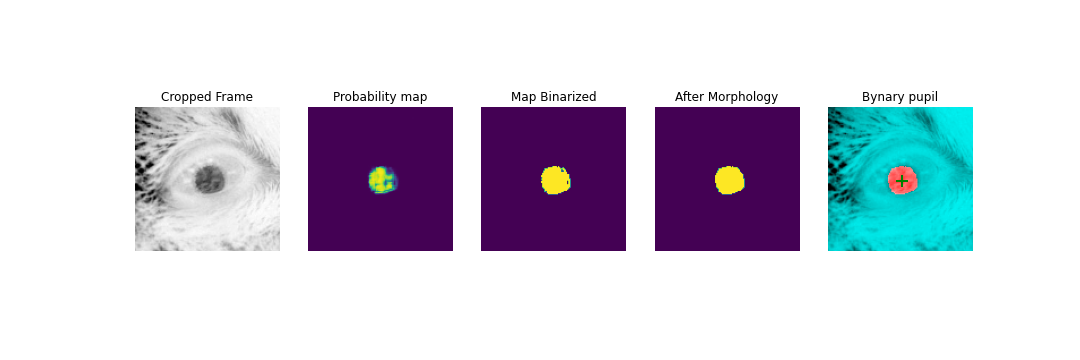

In [114]:
# EDIT PARAMETERS
# ---------------------------------------------------
FRAMENUMBER = 20400 # frame number to analyze. If [] a random frame will be taken 
THRESHOLD = 0.1 # probability threshold for image binarization
IMCLOSING = 13 # pixel radius of circular kernel for morphological closing
INVERTIMAGE = True
# ---------------------------------------------------

cap = cv.VideoCapture(VIDEOPATH)
try:
    numOfFrames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    if not FRAMENUMBER:
        FRAMENUMBER = np.random.randint(1, high=numOfFrames)
    if FRAMENUMBER>numOfFrames:
        print('requested a frame (#{}) beyond video length ({}).'.format(FRAMENUMBER,numOfFrames),end='')
        print(' Analyzing last frame instead')
        FRAMENUMBER=numOfFrames
    cap.set(cv.CAP_PROP_POS_FRAMES,FRAMENUMBER-1) 
    # -1 because CAP_PROP_FRAME_COUNT is 1-based while CAP_PROP_POS_FRAMES is 0-based
    
    # Read a frame from the 
    _, frame = cap.read()
    # Convert to grayscale
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
except:
    print('An error occurred while getting a frame for the video.')
finally:
    cap.release()
    
def cropResize(sourceImg):
    cropped = sourceImg[cropT:cropB, cropL:cropR]
    cropped = cv.resize(cropped,tuple(requiredFrameSize))
    return cropped

def morphProcessing(sourceImg):
    # Binarize 
    binarized = sourceImg > THRESHOLD
    # Divide in regions and keep only the biggest
    label_img = label(binarized)
    regions = regionprops(label_img)
    if len(regions)==0:
        morph = np.zeros(sourceImg.shape, dtype='uint8')
        centroid = (np.nan, np.nan)
        return (morph, centroid)
    regions.sort(key=lambda x: x.area, reverse=True)
    centroid = regions[0].centroid # centroid coordinates of the biggest object
    if len(regions) > 1:
        for rg in regions[1:]:
            label_img[rg.coords[:,0], rg.coords[:,1]] = 0
    label_img[label_img!=0] = 1
    biggestRegion = (label_img*255).astype(np.uint8)
    # Morphological
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(IMCLOSING,IMCLOSING))
    morph = cv.morphologyEx(biggestRegion, cv.MORPH_CLOSE, kernel)
    return (morph, centroid)

croppedFrame = cropResize(frame)

if INVERTIMAGE:
    croppedFrame = cv.bitwise_not(croppedFrame)

mask, info = predict(croppedFrame)

# Extract infos
prediction = mask[0,:,:,0]
eyeProbability = info[0,0]
blinkProbability = info[0,1]

morphedMask, centroid = morphProcessing(prediction)

# Generate falsecolor image
falseColor = np.dstack((morphedMask,croppedFrame,croppedFrame))

# OUTPUT
print('Analyzed image # {} / {}'.format(FRAMENUMBER,numOfFrames))
print('Eye Probability: {:4.2f}%'.format(eyeProbability*100))
print('Blink Probability: {:4.2f}%'.format(blinkProbability*100))

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,5))
ax[0].imshow(croppedFrame, cmap='gray')
ax[0].set_title('Cropped Frame')

ax[1].imshow(prediction,vmin=0, vmax=1)
ax[1].set_title('Probability map')

ax[2].imshow(prediction > THRESHOLD)
ax[2].set_title('Map Binarized')

ax[3].imshow(morphedMask)
ax[3].set_title('After Morphology')

ax[4].imshow(falseColor)
ax[4].plot(centroid[1],centroid[0],marker='+',markersize=12,mew=2,mec='g')
ax[4].set_title('Bynary pupil')

for a in ax.reshape(-1):
    a.axis('off')
plt.show()

## Predict pupil size for the whole video

After adjusting all the parameters on single images in the previous section you can use this section to measure pupilsize on the whole video.  
**This process can be long** (minutes), but having a GPU that tensorflow can use, might shorthen processing time significantly. 

In [103]:
cap = cv.VideoCapture(VIDEOPATH)
numFrames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

df = pd.DataFrame(columns=['frameN','pupilSize','pupCntr_x','pupCntr_y','eyeProb','blinkProb'])

try:
    for i in range(numFrames):
        _, frame = cap.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        croppedFrame = cropResize(frame)
        if INVERTIMAGE:
            croppedFrame = cv.bitwise_not(croppedFrame)
        mask, info = predict(croppedFrame)
        prediction = mask[0,:,:,0]
        morphedMask, centroid = morphProcessing(prediction)
        
        # Extract infos
        eyeProbability = info[0,0]
        blinkProbability = info[0,1]
        
        #Save values for the current frame
        df = df.append({'frameN':int(i+1),
                  'pupilSize':np.sum(morphedMask)/255,
                  'pupCntr_x':centroid[1],
                  'pupCntr_y':centroid[0],
                  'eyeProb':eyeProbability,
                  'blinkProb':blinkProbability},
                  ignore_index=True)
        
        if (i!=0) & (i%400==0) :
            print('Processing frames... ({}/{})'.format(i,numFrames))
finally:
    cap.release()
    winsound.Beep(BEEP_FREQ, BEEP_DURATION_MS)

Processing frames... (400/23236)
Processing frames... (800/23236)
Processing frames... (1200/23236)
Processing frames... (1600/23236)
Processing frames... (2000/23236)
Processing frames... (2400/23236)
Processing frames... (2800/23236)
Processing frames... (3200/23236)
Processing frames... (3600/23236)
Processing frames... (4000/23236)
Processing frames... (4400/23236)
Processing frames... (4800/23236)
Processing frames... (5200/23236)
Processing frames... (5600/23236)
Processing frames... (6000/23236)
Processing frames... (6400/23236)
Processing frames... (6800/23236)
Processing frames... (7200/23236)
Processing frames... (7600/23236)
Processing frames... (8000/23236)
Processing frames... (8400/23236)
Processing frames... (8800/23236)
Processing frames... (9200/23236)
Processing frames... (9600/23236)
Processing frames... (10000/23236)
Processing frames... (10400/23236)
Processing frames... (10800/23236)
Processing frames... (11200/23236)
Processing frames... (11600/23236)
Processing 

## Preprocessing of pupil size
In the following section the estimated pupil size for the whole video will undergo two preprocessing steps:
1. **Blink removal**: Blink events can generate artifacts in the pupil size prediction. We can correct for this by looking at the blink probability for each frame. Frames with a blink probability higher that a threshold (*BLINK_THRESH*) will be rejected and pupil size will be linearly interpolated between the points.
2. **Curve smoothing**: Ofthen the video FrameRate is much higher than the typical timecourse of pupil dilations. The resulting pupil size signal can thus be filtered to increase the saliency of biological fluctuations and remove noise. We implemented a simple *moving median filter*. Users can select an appropiate window size (in frames).
----
You need to specify and eventually adjust 2 parameters:
- **BLINK_THRESH**: Probability threshold for each frame to be classified as a blink
- **MEDIAN_WINDOW**: Window size (in frames) for median filtering. (Usually between 300-900ms works)

<IPython.core.display.Javascript object>


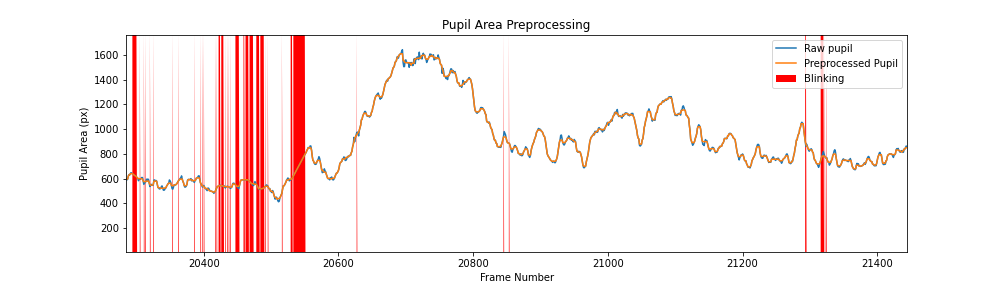

In [105]:
# EDIT PARAMETERS
# ---------------------------------------------------
BLINK_THRESH = 0.01
MEDIAN_WINDOW = 7
# ---------------------------------------------------

%matplotlib notebook
# Remove blinks and interpolate the curve
isBlinking = df['blinkProb'] > BLINK_THRESH
processedPupil = df['pupilSize']
processedPupil[isBlinking] = np.nan
processedPupil.interpolate(inplace=True)
# Moving median filter
processedPupil = processedPupil.rolling(MEDIAN_WINDOW,min_periods=1, center=True).median()
df['processedPupil'] = processedPupil

# Plotting
f, ax = plt.subplots(figsize=(14,4))
ax.plot(df['pupilSize'],label='Raw pupil')
ax.plot(processedPupil, label='Preprocessed Pupil')
ax.fill_between(df['frameN'], ax.get_ylim()[0], ax.get_ylim()[1],
                where=isBlinking, interpolate=True,
                facecolor='red', alpha=1,label='Blinking')
ax.set_title('Pupil Area Preprocessing')
ax.set_xlabel('Frame Number')
ax.set_ylabel('Pupil Area (px)')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc=0)
plt.show()

## Export data as a csv file
The following section will export pupillometry data in a .CSV file.  
By default the file will be saved in the same folder as the movie, with the same filename and `_pupil` appended at the end. If you wish to give a custom name to the output file, you can edit the parameter `CUSTOM_NAME`. Doing this will use this name as the output filename instead.

In [122]:
# EDIT PARAMETERS
# ---------------------------------------------------
CUSTOM_NAME = []
# ---------------------------------------------------

path, fN = os.path.split(VIDEOPATH)
fN, ext =  os.path.splitext(fN)
fN = fN + '_pupil'

if CUSTOM_NAME:
    fN = CUSTOM_NAME

newFileName = path + os.path.sep + fN + '.csv'
df.to_csv(newFileName, index=False) # Export to csv file